Taking in, Covariance matrix, mu and number of points to sample

Objective function is literally just the portfolio's variance which we are minimising for each target return. Taken together, then, the set of all solutions for the set of target returns results in the efficient frontiers<br>
    <center>$\sigma_p^2 = w^T C w$</center>

Cannot, alas, use Lagrangian Optimisation, as we're using range-bounded constraints, rather than strict ones -> using Quadratic Programmming that takes 2nd order Taylor Series multivariate approximation letting $f'(x_0)=0$ and optimises accordingly.

### Constraints

Weights bounded by

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize # Least Squares approach to Quadratic Programming
from numpy.linalg import inv  
from numpy.linalg import pinv  
from sklearn.decomposition import PCA

In [15]:
import yfinance as yf

# if it works, it works
# Fetch S&P 500 company list and sectors from Wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
ticker_data = table[0]
tickers = ticker_data['Symbol'].tolist()
ticker_to_sector = {row['Symbol']: row['GICS Sector'] for index, row in ticker_data.iterrows()}
# Fetch historical data for the latest year
data = yf.download(tickers, start='2022-01-01', end='2023-01-01')['Adj Close']

data.to_csv("data")
sector_df = pd.DataFrame(list(ticker_to_sector.items()), columns=['Ticker', 'Sector'])
sector_df.to_csv("Sectors")

In [50]:
returns = data.pct_change()
returns = returns.iloc[1:]  #removing first zero-row
# annualising
Mu = returns.mean() * returns.shape[0]
cov_matrix = returns.cov() * returns.shape[0]
# getting corr matrix
std_dev = np.sqrt(np.diag(cov_matrix))
std_matrix = np.outer(std_dev, std_dev)
corr_matrix = cov_matrix / std_matrix

In [24]:
cov_matrix

,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.124187,0.080526,0.082022,0.025705,0.028760,0.065081,0.038034,0.083327,0.102514,0.085288,...,0.084333,0.030382,0.030034,0.059762,0.079552,0.048374,0.058969,0.099227,0.065002,0.080266
AAL,0.080526,0.314124,0.115114,0.018880,0.040184,0.068185,0.069188,0.100526,0.118786,0.123698,...,0.178233,0.027127,0.022951,0.068121,0.101748,0.072170,0.084284,0.133304,0.117818,0.069799
AAPL,0.082022,0.115114,0.126240,0.018879,0.033796,0.059149,0.040440,0.093104,0.113906,0.098685,...,0.104884,0.035362,0.033745,0.057517,0.077447,0.049308,0.060869,0.117573,0.075732,0.075549
ABBV,0.025705,0.018880,0.018879,0.049907,0.024650,0.027310,0.014405,0.025059,0.018461,0.024075,...,0.010024,0.019093,0.014064,0.024744,0.021425,0.013413,0.021889,0.018358,0.022398,0.028411
ABC,0.028760,0.040184,0.033796,0.024650,0.055395,0.028607,0.029922,0.031801,0.023580,0.029464,...,0.024241,0.024157,0.023840,0.021162,0.026936,0.020785,0.025951,0.029921,0.029724,0.023286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.048374,0.072170,0.049308,0.013413,0.020785,0.037134,0.029571,0.048042,0.051905,0.055240,...,0.066552,0.021981,0.017091,0.031309,0.048809,0.057659,0.037517,0.064767,0.040924,0.039733
ZBH,0.058969,0.084284,0.060869,0.021889,0.025951,0.050423,0.036802,0.063729,0.068613,0.063137,...,0.067919,0.026097,0.023835,0.057952,0.063669,0.037517,0.092584,0.071939,0.061480,0.052219
ZBRA,0.099227,0.133304,0.117573,0.018358,0.029921,0.071898,0.054954,0.108839,0.134659,0.116515,...,0.130710,0.031354,0.038880,0.073279,0.089026,0.064767,0.071939,0.214276,0.094844,0.086938
ZION,0.065002,0.117818,0.075732,0.022398,0.029724,0.057892,0.052078,0.074379,0.071309,0.077459,...,0.108861,0.029923,0.038688,0.061640,0.070730,0.040924,0.061480,0.094844,0.143775,0.056933


In [25]:
# collecting all data in one df
stock_df = pd.DataFrame({
    'Risk': std_dev,  
    'Return': Mu,  
    'Ticker': tickers,
    'Sector' : sector_list
})

In [26]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(stock_df, x='Risk', y='Return', hover_data=['Ticker'])

fig.add_trace(
    go.Scatter(
        x=[min(stock_df['Risk']), max(stock_df['Risk'])],
        y=[0, 0],
        mode='lines',
        line=dict(color='gray', width=2, dash='dash'),
        name='Zero Return Line'
    )
)

fig.update_layout(
    title='Risk vs Return',
    xaxis=dict(
        title='Risk (Standard Deviation)',
        gridcolor='gray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title='Expected Return',
        gridcolor='gray',
        gridwidth=0.5
    ),
    hoverlabel=dict(
        bgcolor='white',
        font=dict(
            size=16,
            family='Rockwell'
        )
    )
)
fig.show()

In [31]:
def lagrangian_optimisation(returns, target_return=None):
    returns = np.nan_to_num(returns, nan=0.0)
    # Yeah, this is the stuff you don't see. God damn problem of too many redundant securities, and it's not a full rank matrix so ahve to do PCA
    pca = PCA()
    pca.fit(returns)
    
    threshold = 1e-3
    components_to_keep = pca.explained_variance_ > threshold
    returns_transformed = pca.transform(returns)[:, components_to_keep]
    
    cov_matrix_transformed = np.cov(returns_transformed, rowvar=False)
    Mu_transformed = returns_transformed.mean(axis=0)
    
    inv_cov_matrix_transformed = inv(cov_matrix_transformed)
    iota = np.ones(Mu_transformed.shape[0])
    
    if target_return is not None:
        A = Mu_transformed.T @ inv_cov_matrix_transformed @ Mu_transformed
        B = Mu_transformed.T @ inv_cov_matrix_transformed @ iota
        C = iota.T @ inv_cov_matrix_transformed @ iota
        l1 = (C * target_return - B) / (A * C - B ** 2)
        l2 = (A - B * target_return) / (A * C - B ** 2)
        
        w_target = l1 * inv_cov_matrix_transformed @ Mu_transformed + l2 * inv_cov_matrix_transformed @ iota
        return w_target, returns_transformed
    else:
        l = (1/(iota.T @ inv_cov_matrix_transformed @ iota))
        w_min = l * inv_cov_matrix_transformed @ iota 
        return w_min, returns_transformed

In [32]:
def plot_efficient_frontier(returns):
    portfolio_risks = []
    portfolio_returns = []
    
    min_possible_return = np.min(returns.mean(axis=0))
    max_possible_return = np.max(returns.mean(axis=0))
    target_returns = np.linspace(min_possible_return, max_possible_return, 100)
    
    for target in target_returns:
        w_target, returns_transformed = lagrangian_optimisation(returns, target)
        
        portfolio_return = np.dot(w_target, returns_transformed.mean(axis=0))
        portfolio_risk = np.sqrt(w_target.T @ np.cov(returns_transformed, rowvar=False) @ w_target)
        
        portfolio_risks.append(portfolio_risk)
        portfolio_returns.append(portfolio_return)

    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_returns, cmap='viridis')
    plt.colorbar(label='Expected Return')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Expected Return')
    plt.title('Efficient Frontier')
    plt.grid(True)
    plt.show()

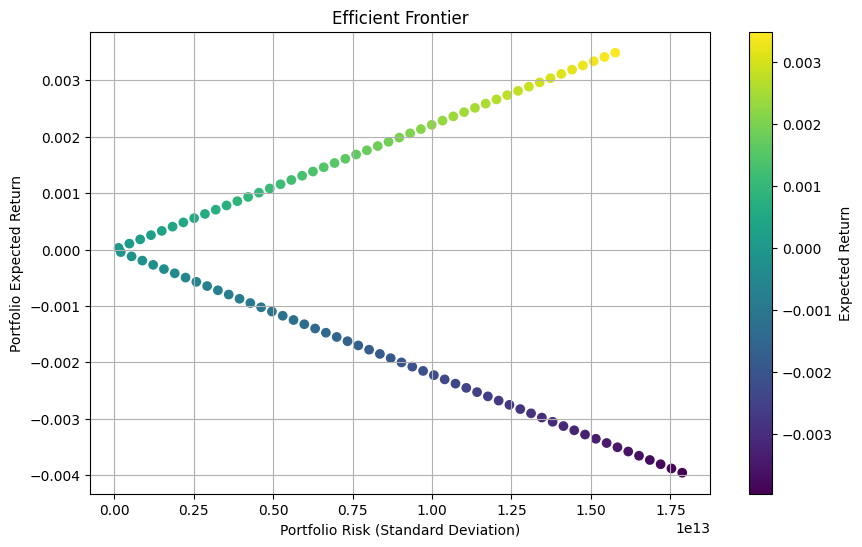

In [33]:
plot_efficient_frontier(returns)

PCA obviously completely contorts efficient frontier? Something has gone fundamentally wrong, and I don't know how to fix it. <br>
Let's use PCA to first select a subset of stocks first to reduce dimensionality

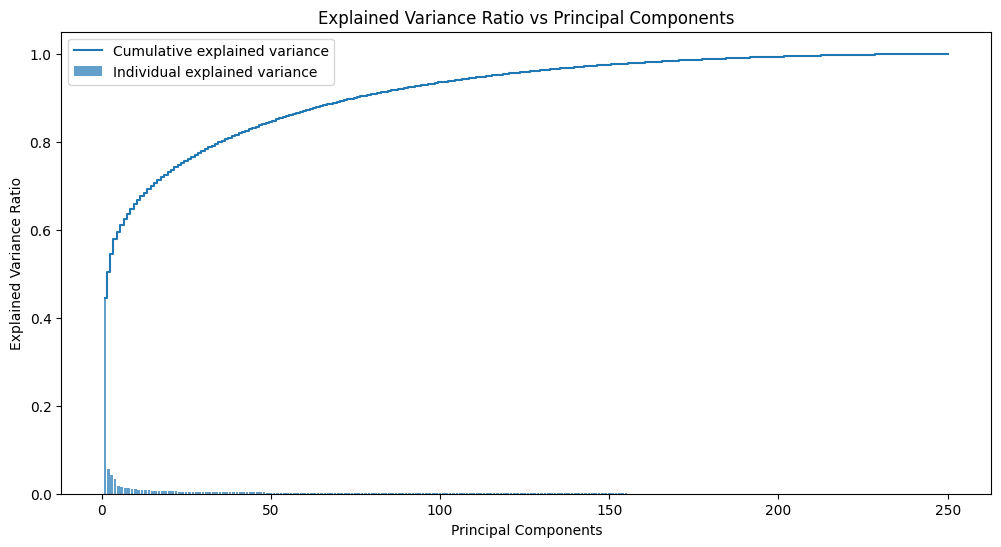

(116,
 array([0.44572652, 0.50292158, 0.54484185, 0.57811399, 0.59478044,
        0.61016013, 0.62396907, 0.63648146, 0.64778143, 0.65841299,
        0.66757757, 0.67624221, 0.68439814, 0.69232523, 0.69958629,
        0.70648304, 0.71321729, 0.71933139, 0.72526785, 0.73107462,
        0.7366913 , 0.74202515, 0.74700966, 0.75194855, 0.75675737,
        0.76136911, 0.76590993, 0.7703707 , 0.7747547 , 0.77896555,
        0.78303301, 0.78701407, 0.79088803, 0.79472657, 0.79845948,
        0.80213132, 0.80572405, 0.8092048 , 0.81256335, 0.81586338,
        0.81911245, 0.8223004 , 0.8254273 , 0.82850654, 0.83145402,
        0.83438235, 0.83726325, 0.84004961, 0.84277325, 0.84546273,
        0.84809103, 0.85069872, 0.85325266, 0.85578103, 0.8582595 ,
        0.86070498, 0.86306698, 0.86541145, 0.86769603, 0.86995764,
        0.87218919, 0.87439445, 0.87654501, 0.87868264, 0.88079759,
        0.88287019, 0.88488559, 0.88683843, 0.88872721, 0.89059421,
        0.89243283, 0.89424036, 0.89601571

In [52]:
returns = np.nan_to_num(returns, nan=0.0)
# Perform PCA on the reduced dataset
pca = PCA()
pca.fit(returns)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio vs Principal Components')
plt.legend(loc='best')
plt.show()

#calculating the number of components to capture 95% variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1  # Adding 1 as index starts from 0

n_components_95, cumulative_explained_variance[:n_components_95]

In [54]:
components = pca.components_

# Get the most significant original dimensions for the first 'n_components_95' principal components
# We'll consider dimensions that have an absolute value of the loading vector greater than a threshold (e.g., 0.3)
threshold = 0.3
significant_dimensions = set()
for i in range(n_components_95):
    significant_dimensions.update(np.where(np.abs(components[i]) >= threshold)[0])

# Convert to a sorted list
significant_dimensions = sorted(list(significant_dimensions))

# Create a subset of the data using only these significant dimensions (securities)
returns_subset = returns[:, significant_dimensions]

# Show the number of selected dimensions and a sample of the new dataset
len(significant_dimensions), returns_subset[:5, :]

(6,
 array([[ 0.01494627, -0.03657737, -0.04550032, -0.00593729, -0.00846631,
         -0.01041226],
        [-0.0257708 , -0.04995884, -0.06019631, -0.03672774, -0.07650391,
         -0.03997294],
        [-0.00472368, -0.01488602,  0.01698234,  0.02557293,  0.00385635,
         -0.02507408],
        [ 0.0393925 , -0.03863223, -0.00264667, -0.00201523, -0.01018234,
         -0.02210411],
        [-0.02283105, -0.01945465,  0.02268211, -0.01121191,  0.09277095,
         -0.00223639]]))

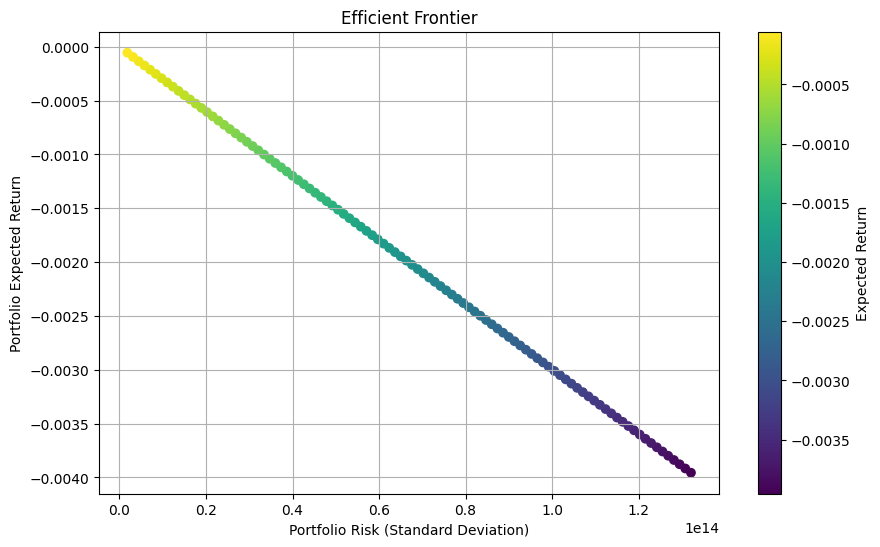

In [55]:
plot_efficient_frontier(returns_subset)

Nope, this is where we give up. 
 So let's just move on to the Monte Carlo method and doing some basic risk analysis in the form of limiting exposure to different sectors

In [ ]:
sector_for_ticker = sector_df.set_index('Ticker').loc['MMM', 'Sector']
sector_for_ticker

In [65]:
def mvef(Covariance, Mu, Npoints):
    Nu = len(Mu)
    Iota = np.ones(Nu)
    
    # Initialize risk and returns
    epsilon = 0.0001
    mu_min = np.min(Mu) + epsilon * (np.mean(Mu) - np.min(Mu))
    mu_max = np.max(Mu) - epsilon * (np.max(Mu) - np.mean(Mu))
    mu_p = np.linspace(mu_min, mu_max, Npoints)
    sigma_p = np.zeros(Npoints)
    w = np.zeros((Nu, Npoints))
    
    # Defining the objective function
    def objective(weights): 
        return weights @ Covariance @ weights
    
    # Constraints
    def constraint1(weights):
        return np.sum(weights) - 1
    
    def constraint2(weights, target_return):
        return Mu @ weights - target_return
    
    # Initial guess
    init_guess = np.repeat(1/Nu, Nu)
    
    # Run optimization
    for k, target_return in enumerate(mu_sample):
        cons = ({'type': 'eq', 'fun': constraint1},
                {'type': 'eq', 'fun': lambda weights: constraint2(weights, target_return)},
                {'type': 'ineq', 'fun': lambda weights: sector_constraints(weights, sector_mapping)})
        
        bounds = [(0, 1) for asset in range(Nu)]
        
        result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
        w[:, k] = result.x
        sigma_p[k] = np.sqrt(result.fun)
        
    return pd.DataFrame({'sigma_p': sigma_p, 'mu_p': mu_p})

In [35]:
def mvmc(Covariance, Mu, Npoints):
    Freq = 12  # Monthly returns
    Years = 18  # 18-year simulation period
    epsilon = 0.0001  # Nudge factor for endpoint rounding
    Nu = len(Mu)
    
    #Monte Carlo simulated returns with multivariate distribution
    Nt = Years * Freq
    HalfCovariance = np.linalg.cholesky(Covariance)
    
    r_sim = np.random.normal(size=(Nt, Nu)) @ HalfCovariance / np.sqrt(Freq) + Mu / Freq

    # Estimate sample means and covariances
    Mu_sim = np.mean(r_sim, axis=0) * Freq
    Covariance_sim = np.cov(r_sim, rowvar=False) * Freq
    
    # Initialize risk and returns
    mu_min = np.min(Mu_sim) + epsilon * (np.mean(Mu_sim) - np.min(Mu_sim))
    mu_max = np.max(Mu_sim) - epsilon * (np.max(Mu_sim) - np.mean(Mu_sim))
    mu_sample = np.linspace(mu_min, mu_max, Npoints)
    
    sigma_sim = np.zeros(Npoints)
    w_sim = np.zeros((Nu, Npoints))
    
    # Define the objective function (negative because scipy minimizes)
    def objective(weights): 
        return weights @ Covariance_sim @ weights
    
    # Constraints
    def constraint1(weights):
        return np.sum(weights) - 1
    
    def constraint2(weights, target_return):
        return Mu_sim @ weights - target_return
    
    # Initial guess
    init_guess = np.repeat(1/Nu, Nu)
    
    # Run optimization
    for k, target_return in enumerate(mu_sample):
        cons = ({'type': 'eq', 'fun': constraint1},
                {'type': 'eq', 'fun': lambda weights: constraint2(weights, target_return)},
                {'type': 'ineq', 'fun': lambda weights: sector_constraints(weights, sector_mapping)})
        
        bounds = [(0, 1) for asset in range(Nu)]
        
        result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
        w_sim[:, k] = result.x
        sigma_sim[k] = np.sqrt(result.fun)
    
    mu_p = np.sum(w_sim.T * Mu, axis=1)
    sigma_p = np.sqrt(np.sum((w_sim.T @ Covariance) * w_sim.T, axis=1))

    return pd.DataFrame({'mu_p': mu_p, 'sigma_p': sigma_p})

In [66]:
def sector_constraints(weights, sector_mapping, tech_max=0.2, finance_max=0.1):
    sector_weights = calculate_sector_weight(weights, sector_mapping)
    tech_weight = sector_weights.get('Information Technology', 0)
    finance_weight = sector_weights.get('Financials', 0)
    
    return min(tech_max - tech_weight, finance_weight - finance_max)

In [67]:
def calculate_sector_weight(weights, sector_mapping):
    sector_weights = {}
    for i, w in enumerate(weights):
        sector = sector_mapping[i]
        if sector in sector_weights:
            sector_weights[sector] += w
        else:
            sector_weights[sector] = w
    return sector_weights

In [71]:
def simulate_efficient_frontier_scenarios(Covariance, Mu, Npoints, sector_mapping):
    plt.figure(figsize=(12, 8))
    
    # No constraints
    result_no_constraints = mvef(Covariance, Mu, Npoints)
    plt.plot(result_no_constraints['sigma_p'], result_no_constraints['mu_p'], label='No Constraints')

    # With Information Technology constraint
    result_it_constraint = mvef_with_sector_constraints(Covariance, Mu, Npoints, sector_mapping, tech_max=0.2, finance_max=1)
    plt.plot(result_it_constraint['sigma_p'], result_it_constraint['mu_p'], label='Information Technology Max 20%')

    # With Financials constraint
    result_finance_constraint = mvef_with_sector_constraints(Covariance, Mu, Npoints, sector_mapping, tech_max=1, finance_max=0.1)
    plt.plot(result_finance_constraint['sigma_p'], result_finance_constraint['mu_p'], label='Financials Max 10%')

    # With both constraints
    result_both_constraints = mvef_with_sector_constraints(Covariance, Mu, Npoints, sector_mapping, tech_max=0.2, finance_max=0.1)
    plt.plot(result_both_constraints['sigma_p'], result_both_constraints['mu_p'], label='Information Technology Max 20%, Financials Max 10%')
    
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Expected Return')
    plt.title('Efficient Frontier Under Different Constraints')
    plt.legend()
    plt.grid(True)
    plt.show()

In [72]:
returns_data = data.pct_change().dropna()
annualized_cov_matrix = returns_data.cov() * 252
annualized_expected_returns = returns_data.mean() * 252

annualized_cov_matrix = annualized_cov_matrix.loc[tickers, tickers]
annualized_expected_returns = annualized_expected_returns[tickers]

c:\Users\oscar\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning:

Mean of empty slice.

c:\Users\oscar\anaconda3\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning:

invalid value encountered in divide

c:\Users\oscar\anaconda3\lib\site-packages\pandas\core\frame.py:10217: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\oscar\anaconda3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

divide by zero encountered in divide

c:\Users\oscar\anaconda3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

invalid value encountered in multiply



In [73]:
simulate_efficient_frontier_scenarios(annualized_cov_matrix, annualized_expected_returns, 100, asset_to_sector_map)

NameError: name 'asset_to_sector_map' is not defined